In [1]:
import os
from collections import Counter, defaultdict

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import probscale
import itertools
import csv

from pathlib import Path

plt.rcParams.update({'font.size': 14, 'figure.autolayout': True})

class Result:
    def __init__(self, path):
        self.path = Path("results").joinpath(path, "flamestream")
    
    def lat_data(self):
        with open(self.path.joinpath("latency/lat.data"), 'r') as file:
            return list(filter(lambda x: x > 0, map(lambda x: int(x) / 1E9, file.read().split(", "))))
    
    def notification_await_times(self):
        with open(self.path.joinpath("notification_await_times.csv"), 'r') as file:
            return list(map(lambda row: int(row[0]) / 1E6, csv.reader(file)))
        
    def duration(self):
        with open(self.path.joinpath("duration.txt"), 'r') as file:
            return int(file.read())
        
    def durations(self):
        with open(self.path.joinpath("durations.txt"), 'r') as file:
            return list(map(int, file.read().split(", ")))
    
    def throughput_hz(self, skip=0):
        durations = self.durations()
        return (len(durations) - skip) / (durations[-1] - durations[skip]) * 1E9

    def plot_latencies_evolution(self, **kwargs):
        plot_quantiles_evolution(self.lat_data(), **kwargs)
        
    def acker(self):
        partitions = [
            dict([line.split(" = ") for line in Path(path).read_text().splitlines()])
            for path in self.path.glob('acker/*')
        ]
        keys = sum(tuple(map(lambda partition: tuple(partition.keys()), partitions)), ())
        return defaultdict(lambda: 0, {
          key: sum(int(partition[key]) for partition in partitions)
          for key in keys
        })
    
    def min_time_updates_sent(self):
      return self.acker()['minTimeUpdatesSent'] * self.vars()['parallelism']
    
    def traffic(self):
        acker = self.acker()
        vars = self.vars()
        return acker.get('bufferedMessagesHandled', 0) + self.min_time_updates_sent() +\
          (acker['acksReceived'] + acker['heartbeatsReceived']
           if vars['worker_environment']['LOCAL_ACKER_FLUSH_COUNT'] == 0
           else 0)\
               + self.class_addressed_items_number().get('com.spbsu.flamestream.example.bl.WatermarksVsAckerGraph.Watermark', 0)
    
    def vars(self):
      return json.loads(self.path.joinpath("../vars.json").read_text())
    
    def class_addressed_items_number(self):
        partitions = [
            dict([line.split(",") for line in Path(path).read_text().splitlines()])
            for path in self.path.glob('class_addressed_items_number/*')
        ]
        keys = sum(tuple(map(lambda partition: tuple(partition.keys()), partitions)), ())
        return {
          key: sum(int(partition.get(key, 0)) for partition in partitions)
          for key in keys
        }
    
    def snapshots(self):
        partitions = [
            dict([line.split(",") for line in Path(path).read_text().splitlines()])
            for path in self.path.glob('snapshots/*.csv')
        ]
        keys = sum(tuple(map(lambda partition: tuple(partition.keys()), partitions)), ())
        return defaultdict(lambda: 0, {
          key: sum(int(partition[key]) for partition in partitions)
          for key in keys
        })
    
    def snapshot_duration(self):
      return self.vars()['worker_environment']['SNAPSHOTS_DURATION_MS']
        
    def last_in_window_notification_await_times(self):
      return [min(slice) for slice in each_slice(
        self.notification_await_times(),
        self.vars()['tracking_frequency'] * self.vars()['parallelism'],
      )]
        
def plot_quantiles_evolution(data, window_size=100, q=0.95, stabilize=True):
    quantiles = []
    prev_quantile = None
    is_stable = not stabilize
    for window in each_slice(data, window_size):
        quantile = np.quantile(window, q)
        if is_stable:
            quantiles.append(quantile)
        elif prev_quantile and prev_quantile < quantile:
            is_stable = True
            quantiles.append(prev_quantile)
            quantiles.append(quantile)
        else:
            prev_quantile = quantile
        prev_window = window
    if not is_stable:
        raise "has not stabilized"
    plt.plot(quantiles)
        
def results_path(parallelism=3, rate=5, watermarks=False):
    return Path(f"results/sigmod/parallelism={parallelism}/distributed_acker={False}/rate={rate}/watermarks={watermarks}/iterations=10/flamestream")

def plot_probabilities(results_by_legends, legend_title=None, plot_title=None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.legend(results_by_legends.keys(), title=legend_title)
    for result in results_by_legends.values():
        plt.plot(*probscale.plot_pos(result.lat_data()))
    plt.xlabel('Percentile')
    plt.ylabel('Latency, ns')
    plt.title(plot_title)
    plt.show()
    
def plot_percentile(percentile, results_by_rates):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(
        results_by_rates.keys(),
        [np.percentile(result.lat_data(), percentile) for result in results_by_rates.values()],
        marker='o'
    )
    plt.xlabel('Rate')
    plt.ylabel(f"Latencies {percentile} percentile, ns")
    
def plot_percentile_by_throughput(percentile, results):
    plt.plot(*plottable_percentile_by_throughput(percentile, results))
    
def plottable_percentile_by_throughput(percentile, results):
    return (
        [result.throughput() for result in results],
        [np.percentile(result.lat_data(), percentile) for result in results]
    )

def plot_throughput_by_number_of_iterations(results):
    plt.plot(
        [result.iterations for result in results],
        [result.throughput() for result in results],
    )
    
def show_max_throughput(result_factory, bad_rate, max_rate):
    pass

def plot_throughput_by_parallelism(results):
    plt.plot(
        [result.parallelism for result in results],
        [result.throughput_hz() for result in results],
    )
    
def plot_latencies_barh(results_by_labels, ax):
    w = .70
    ind_fs = [1, 2.0, 3.0]

    def do_plot(q, c):
        ax.barh(range(len(results_by_labels)), [np.percentile(result.lat_data(), q) for result in results_by_labels.values()], color=c, height=w, left=0)

    do_plot(99, '.8')
    do_plot(90, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')

    plt.gca().invert_yaxis()

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(60)

    ax.set_yticklabels([])
#     plt.xlim((0, np.percentile(latencies[8], 99) + 100))

    ax.set_xlabel('Latency(ms)', fontsize=60)

    for i, label in enumerate(results_by_labels):
        ax.text(np.percentile(results_by_labels[label].lat_data(), 99) + 10, i, label, fontsize = 60)

    patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
    patch_90 = mpatches.Patch(color='.6', label='95 %-ile')
    patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
    patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
    ax.legend(handles=[patch_99, patch_90, patch_75, patch_50][::-1], fontsize = 60, frameon=False, bbox_to_anchor=(1, 1), ncol=1)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
def each_slice(generator, n):
    group = []
    for element in generator:
        group.append(element)
        if len(group) == n:
            yield group
            group = []

    if group:
        yield group

fig = plt.gcf()

In [2]:
from glob import glob
import json
from pathlib import Path

all_results = [
  Result(Path(path).absolute())
  for path in glob('results/sigmod.10.30_/*')
  if Path(path).joinpath("vars.json").exists()
]

def result_grouper_key(result):
  return (
    result.vars()['tracking'],
    result.vars().get('distributed_acker'),
    result.vars()['worker_environment']['LOCAL_ACKER_FLUSH_COUNT'],
  )

tracking_results = {
  'Markers' if tracking == 'watermarking' else
  'Disabled' if tracking == 'disabled' else
    ("trAcker"):
        list(results)
    for (tracking, distributed_acker, local_acker_flush_count), results in itertools.groupby(
      sorted([
        result
        for result in all_results
      ], key=result_grouper_key),
      key=result_grouper_key,
    )
}

In [3]:
{
  legend: sorted([
    (result.snapshots())
    for result in results
    # if result.vars()['iterations'] == 100
    #     and result.vars()['parallelism'] == 15
  ], key=lambda tuple: tuple[0])
  for legend, results in tracking_results.items()
}

{'Markers': [defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 2360559011, 'buffered_count': 367, 0: 0}),
  defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 19023487768,
               'buffered_count': 1213,
               0: 0}),
  defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 62469935881,
               'buffered_count': 2200,
               0: 0})],
 'trAcker': [defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 104922450390,
               'buffered_count': 555,
               0: 0}),
  defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 1627098401, 'buffered_count': 103, 0: 0}),
  defaultdict(<function __main__.Result.snapshots.<locals>.<lambda>>,
              {'buffering_duration': 28278232970,
           

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


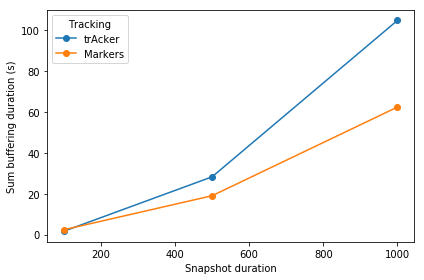

<Figure size 432x288 with 0 Axes>

In [4]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (
      result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'],
      result.snapshots()['buffering_duration'] / 1E9,
    )
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
], title='Tracking')
plt.xlabel('Snapshot duration')
plt.ylabel('Sum buffering duration (s)')
plt.show()
plt.draw()
fig.savefig('buffering_sum_duration.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


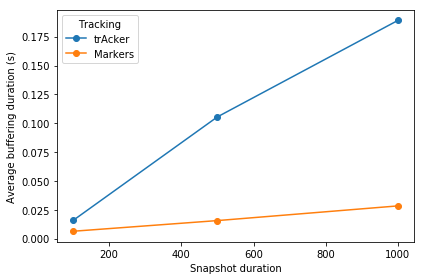

<Figure size 432x288 with 0 Axes>

In [5]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (
      result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'],
      result.snapshots()['buffering_duration'] / result.snapshots()['buffered_count'] / 1E9,
    )
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
], title='Tracking')
plt.xlabel('Snapshot duration')
plt.ylabel('Average buffering duration (s)')
plt.show()
plt.draw()
fig.savefig('buffering_average_duration.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


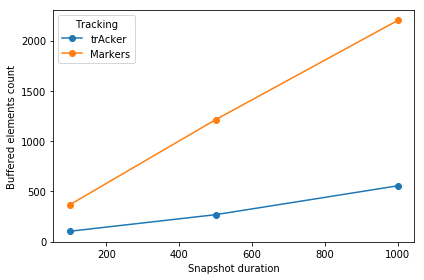

<Figure size 432x288 with 0 Axes>

In [6]:
fig = plt.gcf()
plt.legend([
  plt.plot(*zip(*sorted([
    (result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'], result.snapshots()['buffered_count'])
    for result in results
    if result.vars()['iterations'] == 30
        and result.vars()['parallelism'] == 15
  ])), marker='o') and legend
  for legend, results in tracking_results.items()
], title='Tracking')
plt.xlabel('Snapshot duration')
plt.ylabel('Buffered elements count')
plt.show()
plt.draw()
fig.savefig('buffering_count.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


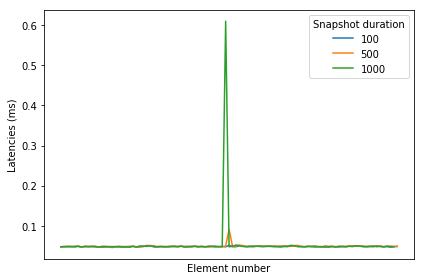

<Figure size 432x288 with 0 Axes>

In [7]:
plt.legend([
  plot_quantiles_evolution(result.lat_data(), q=0.5) or result.snapshot_duration()
  for result in sorted(tracking_results['trAcker'], key=lambda result: result.snapshot_duration())
], title='Snapshot duration')
plt.xticks([])
plt.xlabel('Element number')
plt.ylabel('Latencies (ms)')
plt.show()
plt.draw()
fig.savefig('buffering_latencies_evolution_acker.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


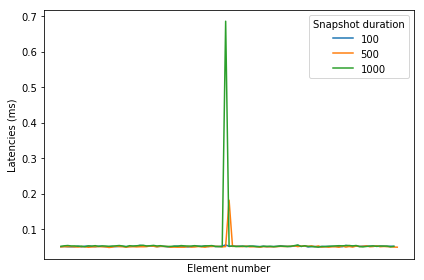

<Figure size 432x288 with 0 Axes>

In [8]:
plt.legend([
  plot_quantiles_evolution(result.lat_data(), q=0.5) or result.snapshot_duration()
  for result in sorted(tracking_results['Markers'], key=lambda result: result.snapshot_duration())
], title='Snapshot duration')
plt.xticks([])
plt.xlabel('Element number')
plt.ylabel('Latencies (ms)')
plt.show()
plt.draw()
fig.savefig('buffering_latencies_evolution_watermarks.png')
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


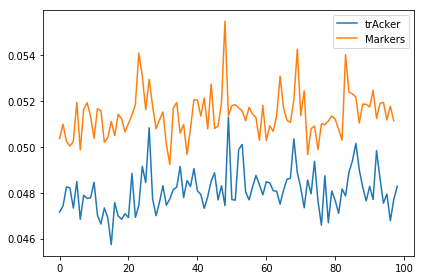

In [9]:
fig = plt.gcf()
plt.legend([
  plot_quantiles_evolution(result.lat_data(), q=0.5) or legend
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 100
])
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


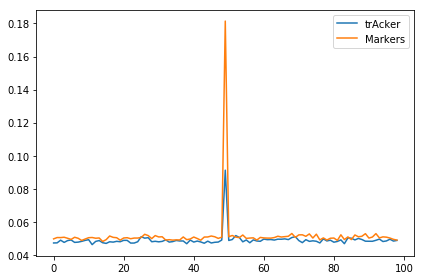

In [10]:
fig = plt.gcf()
plt.legend([
  plot_quantiles_evolution(result.lat_data(), q=0.5) or legend
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 500
])
None

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


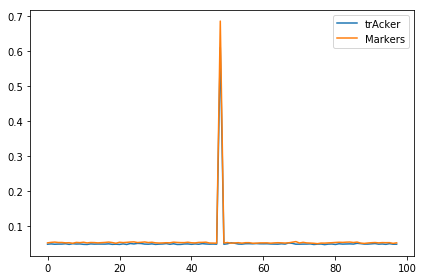

In [11]:
fig = plt.gcf()
plt.legend([
  plot_quantiles_evolution(result.lat_data(), q=0.5) or legend
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 1000
])
None

In [12]:
{
  legend: {
    quantile: np.quantile(result.lat_data(), quantile)
      for quantile in [0.5, 0.75, 0.90, 0.99]
  }
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 100
}

{'Markers': {0.5: 0.051396631,
  0.75: 0.055046001,
  0.9: 0.0584287235,
  0.99: 0.06711787780000002},
 'trAcker': {0.5: 0.0480428675,
  0.75: 0.05119132025,
  0.9: 0.0545146575,
  0.99: 0.0613049674}}

In [16]:
{
  legend: {
    quantile: np.quantile(result.lat_data(), quantile)
      for quantile in [0.5, 0.75, 0.90, 0.99]
  }
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 1000
}

{'Markers': {0.5: 0.0519466955,
  0.75: 0.05565419375,
  0.9: 0.0595449532,
  0.99: 0.1844201789800026},
 'trAcker': {0.5: 0.0482731395,
  0.75: 0.051718769,
  0.9: 0.0551073825,
  0.99: 0.09368741807000094}}

In [15]:
{
  legend: {
    quantile: np.quantile(result.lat_data(), quantile)
      for quantile in [0.5, 0.75, 0.90, 0.99]
  }
  for legend, results in tracking_results.items()
  for result in results
  if result.vars()['worker_environment']['SNAPSHOTS_DURATION_MS'] == 500
}


{'Markers': {0.5: 0.050495621500000004,
  0.75: 0.054076400499999996,
  0.9: 0.0576610903,
  0.99: 0.06895699106000001},
 'trAcker': {0.5: 0.048624244,
  0.75: 0.051945184500000005,
  0.9: 0.055143595700000006,
  0.99: 0.06540779578000001}}